In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np 

%matplotlib inline 

from pathlib import Path

import matplotlib.pyplot as plt 
import os 
from keras import layers 
from keras.models import Model
from keras.models import load_model
from keras import callbacks 
import cv2 
import string

In [ ]:
#load dataset from Google Drive
data_dir = Path("/content/drive/My Drive/samples_ai")

images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

#total no of images in dataset
size=len(os.listdir(data_dir))

img_height=150
img_width=400

#defining size of image
imgshape=(img_height,img_width,1) #50-height, 200-width, 1-no of channels

character= string.ascii_lowercase + "0123456789" # All symbols captcha can contain
nchar = len(character) #total number of char possible

print(size)

9999


In [ ]:
#Pre-processs image
def preprocess():
  X = np.zeros((size,img_height,img_width,1)) #1070*50*200 array with all entries 0
  y = np.zeros((5,size,nchar)) #5*1070*36(5 letters in captcha) with all entries 0

  for i, pic in enumerate(os.listdir(data_dir)):
  #i represents index no. of image in directory 
  #pic contains the file name of the particular image to be preprocessed at a time
    
    img = cv2.imread(os.path.join(data_dir, pic), cv2.IMREAD_GRAYSCALE) #Read image in grayscale format
    label = pic[:-4]#this drops the .png extension from file name and contains only the captcha for training
    
    if len(label) < 6: #captcha is not more than 5 letters
      img = img / 255.0 #scales the image between 0 and 1
      img = np.reshape(img, (150, 400, 1)) #reshapes image to width 200 , height 50 ,channel 1 

      target=np.zeros((5,nchar)) #creates an array of size 5*36 with all entries 0

      for j, k in enumerate(label):
      #j iterates from 0 to 4(5 letters in captcha)
      #k denotes the letter in captcha which is to be scanned
         index = character.find(k) #index stores the position of letter k of captcha in the character string
         target[j, index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha

      X[i] = img #stores all the images
      y[:,i] = target #stores all the info about the letters in captcha of all images

  return X,y

In [ ]:
X,y=preprocess()

train_size = 0.9
train_samples = int(size*train_size)

#split the "size" samples where "0.9*size" samples will be used for training purpose
X_train, y_train = X[:train_samples], y[:, :train_samples]
X_test, y_test = X[train_samples:], y[:, train_samples:]

In [27]:
#create model
def createmodel():
    img = layers.Input(shape=imgshape) # Get image as an input of size 50,200,1
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img) #50*200
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 25*100
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 13*50
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3) #to improve the stability of model
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 7*25
    
    flat = layers.Flatten()(mp3) #convert the layer into 1-D

    outs = []
    for _ in range(5): #for 5 letters of captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        res = layers.Dense(nchar, activation='sigmoid')(drop)

        outs.append(res) #result of layers
    
    # Compile model and return it
    model = Model(img, outs) #create model
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [28]:
#Create model
model=createmodel();
model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 400, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 400, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 75, 200, 16)  0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=200, validation_split=0.2)

Epoch 1/200
225/225 [==============================] - 25s 53ms/step - loss: 17.9449 - dense_1_loss: 3.5880 - dense_3_loss: 3.5881 - dense_5_loss: 3.5888 - dense_7_loss: 3.5899 - dense_9_loss: 3.5901 - dense_1_accuracy: 0.0286 - dense_3_accuracy: 0.0306 - dense_5_accuracy: 0.0292 - dense_7_accuracy: 0.0281 - dense_9_accuracy: 0.0299 - val_loss: 17.9186 - val_dense_1_loss: 3.5838 - val_dense_3_loss: 3.5833 - val_dense_5_loss: 3.5849 - val_dense_7_loss: 3.5831 - val_dense_9_loss: 3.5835 - val_dense_1_accuracy: 0.0294 - val_dense_3_accuracy: 0.0300 - val_dense_5_accuracy: 0.0283 - val_dense_7_accuracy: 0.0311 - val_dense_9_accuracy: 0.0294
Epoch 2/200
225/225 [==============================] - 9s 40ms/step - loss: 17.9073 - dense_1_loss: 3.5816 - dense_3_loss: 3.5822 - dense_5_loss: 3.5799 - dense_7_loss: 3.5808 - dense_9_loss: 3.5828 - dense_1_accuracy: 0.0349 - dense_3_accuracy: 0.0300 - dense_5_accuracy: 0.0354 - dense_7_accuracy: 0.0350 - dense_9_accuracy: 0.0313 - val_loss: 17.9935 -

In [ ]:
preds = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]])
print ("Loss on training set= " + str(preds[0]))

NameError: ignored

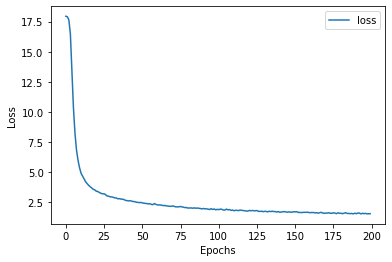

In [ ]:
#graph of loss vs epochs
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
#to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None: #image foud at file path
        img = img / 255.0 #Scale image
    else:
        print("Not detected");

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis])) #np.newaxis=1 
    #added this bcoz x_train 970*50*200*1
    #returns array of size 1*5*36 
    result = np.reshape(res, (5, 36)) #reshape the array
    k_ind = []
    probs = []
    for i in result:
        k_ind.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = '' #string to store predicted captcha
    for k in k_ind:
        capt += character[k] #finds the char corresponding to the index
    return capt 

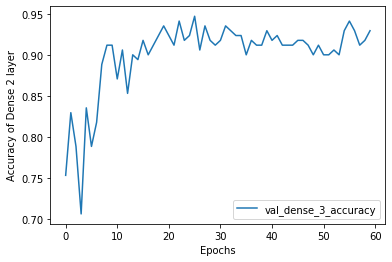

In [ ]:
#graph of accuracy of dense_2 vs epochs
for label in ["val_dense_3_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 2 layer")
plt.show()

Predicted Captcha = 3n0mz


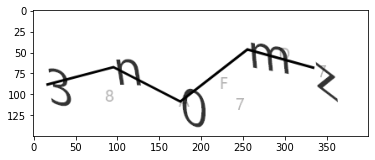

In [ ]:
#Check model on samples
sample_test_dir = "/content/drive/My Drive/samples_ai/3n0mz.png"
img=cv2.imread(sample_test_dir,cv2.IMREAD_UNCHANGED)
plt.imshow(img, cmap=plt.get_cmap('gray'))

print("Predicted Captcha =",predict(sample_test_dir))

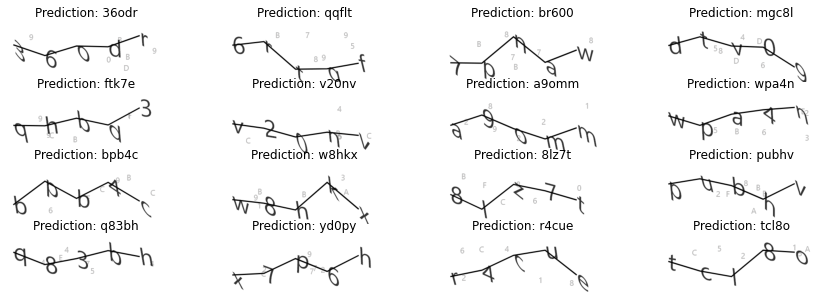

In [ ]:
_ , ax = plt.subplots(4, 4, figsize=(15, 5))
np.random.shuffle(images)
for i in range(16):
  img = cv2.imread(images[i],cv2.IMREAD_UNCHANGED)
  title = f"Prediction: {predict(images[i])}"
  ax[i // 4, i % 4].imshow(img, cmap=plt.get_cmap('gray'))
  ax[i // 4, i % 4].set_title(title)
  ax[i // 4, i % 4].axis("off")
plt.show()